Landscape Image Classification Project by CNN Transfer Learning with Fine Tuning - Dataset as taken from Kaggle

https://www.kaggle.com/datasets/utkarshsaxenadn/landscape-recognition-image-dataset-12k-images

# Importing dataset from Kaggle

In [ ]:
!nvidia-smi

Wed Jan  4 15:27:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    34W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

from google.colab import files
files.upload()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!pwd

-rw-r--r-- 1 root root 66 Jan  4 14:01 kaggle.json
/content


In [ ]:
!kaggle datasets download -d utkarshsaxenadn/landscape-recognition-image-dataset-12k-images

landscape-recognition-image-dataset-12k-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!# Get helper functions file
import os 

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

[INFO] 'helper_functions.py' already exists, skipping download.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Import series of helper functions for the notebook 
from helper_functions import create_tensorboard_callback, load_and_prep_image, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, make_confusion_matrix

In [ ]:
unzip_data('landscape-recognition-image-dataset-12k-images.zip')

In [ ]:
# Walk through  data directory and list number of files
walk_through_dir("Landscape Classification")

There are 1 directories and 0 images in 'Landscape Classification'.
There are 4 directories and 0 images in 'Landscape Classification/Landscape Classification'.
There are 5 directories and 0 images in 'Landscape Classification/Landscape Classification/Testing Data'.
There are 0 directories and 100 images in 'Landscape Classification/Landscape Classification/Testing Data/Coast'.
There are 0 directories and 100 images in 'Landscape Classification/Landscape Classification/Testing Data/Desert'.
There are 0 directories and 100 images in 'Landscape Classification/Landscape Classification/Testing Data/Forest'.
There are 0 directories and 100 images in 'Landscape Classification/Landscape Classification/Testing Data/Mountain'.
There are 0 directories and 100 images in 'Landscape Classification/Landscape Classification/Testing Data/Glacier'.
There are 5 directories and 0 images in 'Landscape Classification/Landscape Classification/Training Data'.
There are 0 directories and 2000 images in 'Lands

In [ ]:
train_dir_path = 'Landscape Classification/Landscape Classification/Training Data'
test_dir_path = 'Landscape Classification/Landscape Classification/Testing Data'
validation_dir_path = 'Landscape Classification/Landscape Classification/Validation Data'

In [ ]:
IMG_SIZE = (224, 224) # define image size
BATCH_SIZE = 32
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_path,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels
                                                                            batch_size=BATCH_SIZE, # batch_size is 32 by default
                                                                            shuffle = True) 

validation_data = tf.keras.preprocessing.image_dataset_from_directory(directory=validation_dir_path,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical",
                                                                           batch_size=BATCH_SIZE,
                                                                           shuffle = True)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir_path,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical",
                                                                           shuffle = False)
     

Found 10000 files belonging to 5 classes.
Found 1500 files belonging to 5 classes.
Found 500 files belonging to 5 classes.


In [ ]:
test_data.class_names[0:]

['Coast', 'Desert', 'Forest', 'Glacier', 'Mountain']

In [ ]:
# Check the training data datatype
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [ ]:
# Check out the class names of our dataset
train_data.class_names

['Coast', 'Desert', 'Forest', 'Glacier', 'Mountain']

In [ ]:
# See an example batch of data
for images, labels in train_data.take(1):
  print(images[0], labels[0])

tf.Tensor(
[[[  9.         58.        135.       ]
  [  9.         58.        135.       ]
  [  9.390625   58.390625  135.39062  ]
  ...
  [ 25.828125   76.390625  153.78125  ]
  [ 27.         76.        153.       ]
  [ 27.         76.        153.       ]]

 [[  9.06243    58.06243   135.06242  ]
  [  9.799107   58.799107  135.7991   ]
  [  9.877581   58.877583  135.87758  ]
  ...
  [ 24.854214   76.87758   153.78125  ]
  [ 26.625418   76.187294  153.       ]
  [ 27.         76.        153.       ]]

 [[  9.026158   60.021694  136.35652  ]
  [  9.334822   60.330357  136.66518  ]
  [  9.334822   60.330357  136.66518  ]
  ...
  [ 25.274553   77.66518   154.44643  ]
  [ 26.177874   77.40883   153.66518  ]
  [ 26.334822   77.33036   153.66518  ]]

 ...

 [[  7.4962897   8.161482    4.1659064]
  [ 11.005648   11.74931     7.830131 ]
  [  4.1135693   5.1135693   1.4474096]
  ...
  [  6.2843847   5.5195894   2.5633764]
  [  7.6970415   9.380808    4.366658 ]
  [  9.84852    11.844095    6.51

In [ ]:
# See an example batch of data
for images, labels in test_data.take(1):
  print(images[0], labels[0])

tf.Tensor(
[[[  0.       113.       184.      ]
  [  0.       113.25446  184.25447 ]
  [  0.       114.       185.      ]
  ...
  [ 38.513733  49.513733   6.513733]
  [ 42.69168   53.69168   11.437195]
  [ 47.830322  58.830322  16.830322]]

 [[  0.       113.       184.      ]
  [  0.       113.25446  184.25447 ]
  [  0.       114.       185.      ]
  ...
  [ 41.228535  52.228535   9.681   ]
  [ 42.134117  53.134117  11.079585]
  [ 44.03507   55.03507   13.035069]]

 [[  0.       113.       184.      ]
  [  0.       113.25446  184.25447 ]
  [  0.       114.       185.      ]
  ...
  [ 42.92439   53.92439   12.513314]
  [ 42.168724  53.168724  12.454439]
  [ 41.714287  52.714287  12.      ]]

 ...

 [[  0.         0.         0.      ]
  [  0.         0.         0.      ]
  [  0.         0.         0.      ]
  ...
  [  0.         0.         0.      ]
  [  0.         0.         0.      ]
  [  0.         0.         0.      ]]

 [[  0.         0.         0.      ]
  [  0.         0.        

In [ ]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [ ]:
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

## Visualizing the data

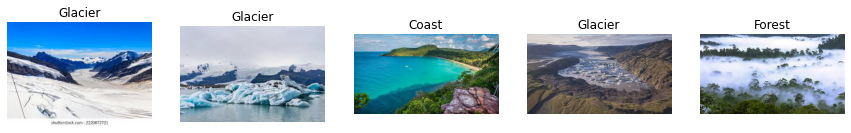

In [ ]:
# Plot multiple random images from the traning dataset
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
plt.figure(figsize=(15, 15))
for i in range(5):
  target_class = random.choice(train_data.class_names) # choose a random class
  target_dir = "/content/Landscape Classification/Landscape Classification/Training Data/" + target_class # create the target directory
  random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
  random_image_path = target_dir + "/" + random_image # create the choosen random image path
  img = mpimg.imread(random_image_path) # read in the chosen target image
  ax = plt.subplot(1, 5, i + 1)
  plt.imshow(img)
  plt.title(target_class)
  plt.axis(False)

# Model 0: Building a transfer learning model using the Keras Functional API

In [ ]:
# Create checkpoint callback to save model for later use
checkpoint_model_0_path = "/content/model_0_checkpoint"
checkpoint_callback_model_0 = tf.keras.callbacks.ModelCheckpoint(checkpoint_model_0_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)

In [ ]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(5, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_model_0 = model_0.fit(train_data,
                                 epochs=5,
                                 steps_per_epoch=len(train_data),
                                 validation_data=validation_data,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps= int(0.25*len(validation_data)), 
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback(dir_name = "Tensor_Board",
                                                                        experiment_name = "Transfer_learning_feature_extraction_5_epochs"),
                                            checkpoint_callback_model_0])

Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: Tensor_Board/Transfer_learning_feature_extraction_5_epochs/20230104-152844
Epoch 1/5
313/313 [==============================] - 36s 82ms/step - loss: 0.5429 - accuracy: 0.8240 - val_loss: 0.5742 - val_accuracy: 0.7955
Epoch 2/5
313/313 [==============================] - 24s 76ms/step - loss: 0.3486 - accuracy: 0.8811 - val_loss: 0.4169 - val_accuracy: 0.8665
Epoch 3/5
313/313 [==============================] - 24s 77ms/step - loss: 0.3175 - accuracy: 0.8920 - val_loss: 0.5058 - val_accuracy: 0.8267
Epoch 4/5
313/313 [==============================] - 24s 75ms/step - loss: 0.2929 - accuracy: 0.9030 - val_loss: 0.4960 - val_accuracy: 0.8210
Epoch 5/5
313/313 [==============================] - 24s 76ms/step - loss: 0.2760 - accuracy: 0.9070 - val_loss: 0.5295 - val_accuracy: 0.8125


In [ ]:
# Check 20 last layers in our base model
for layer_number, layer in enumerate(base_model.layers[-20:]):
  print(layer_number, layer.name)

0 block6d_project_conv
1 block6d_project_bn
2 block6d_drop
3 block6d_add
4 block7a_expand_conv
5 block7a_expand_bn
6 block7a_expand_activation
7 block7a_dwconv
8 block7a_bn
9 block7a_activation
10 block7a_se_squeeze
11 block7a_se_reshape
12 block7a_se_reduce
13 block7a_se_expand
14 block7a_se_excite
15 block7a_project_conv
16 block7a_project_bn
17 top_conv
18 top_bn
19 top_activation


In [ ]:
# Check summary of model constructed with Functional API
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 5)                 6405      
                                                                 
Total params: 4,055,976
Trainable params: 6,405
Non-trainable params: 4,049,571
_________________________________________________________________


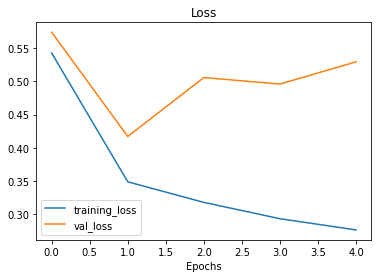

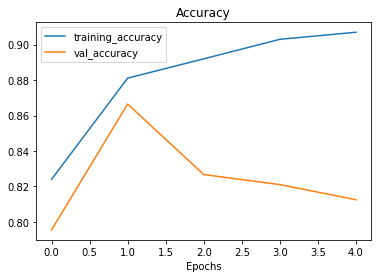

In [ ]:
# Check out our model's training curves
plot_loss_curves(history_model_0)

In [ ]:
result_model_0 = model_0.evaluate(test_data)

16/16 [==============================] - 2s 104ms/step - loss: 0.2876 - accuracy: 0.8880


#Model 1: Building a transfer learning model using the Keras Functional API

In [ ]:
# Create checkpoint callback to save model for later use
checkpoint_model_1_path = "/content/model_1_checkpoint"
checkpoint_callback_model_1 = tf.keras.callbacks.ModelCheckpoint(checkpoint_model_1_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)

In [ ]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(5, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_1 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_1.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_model_1 = model_1.fit(train_data,
                                 epochs=10,
                                 steps_per_epoch=len(train_data),
                                 validation_data=validation_data,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps= int(0.25* len(validation_data)), 
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback(dir_name = "Tensor_Board",
                                                                        experiment_name = "Transfer_learning_feature_extraction_10_epochs"),
                                            checkpoint_callback_model_1])

Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: Tensor_Board/Transfer_learning_feature_extraction_10_epochs/20230104-153136
Epoch 1/10
313/313 [==============================] - 31s 82ms/step - loss: 0.5245 - accuracy: 0.8316 - val_loss: 0.4981 - val_accuracy: 0.8352
Epoch 2/10
313/313 [==============================] - 24s 75ms/step - loss: 0.3524 - accuracy: 0.8817 - val_loss: 0.5128 - val_accuracy: 0.8295
Epoch 3/10
313/313 [==============================] - 24s 76ms/step - loss: 0.3167 - accuracy: 0.8920 - val_loss: 0.4638 - val_accuracy: 0.8295
Epoch 4/10
313/313 [==============================] - 24s 76ms/step - loss: 0.2945 - accuracy: 0.9020 - val_loss: 0.5114 - val_accuracy: 0.8182
Epoch 5/10
313/313 [==============================] - 24s 76ms/step - loss: 0.2787 - accuracy: 0.9065 - val_loss: 0.5324 - val_accuracy: 0.8068
Epoch 6/10
313/313 [==============================] - 24s 76ms/step - loss: 0.2662 

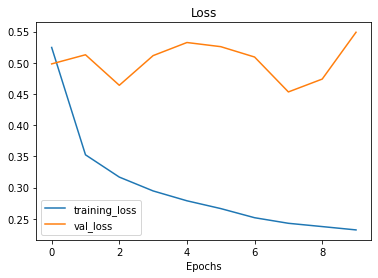

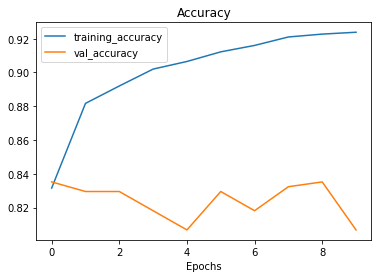

In [ ]:
# Check out our model's training curves
plot_loss_curves(history_model_1)

In [ ]:
result_model_1 = model_1.evaluate(test_data)

16/16 [==============================] - 1s 78ms/step - loss: 0.2784 - accuracy: 0.8880


#Model 2: Feature extraction transfer learning 5 epochs with data augmentation

###Adding data augmentation right into the model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal",),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2)
], name ="data_augmentation")

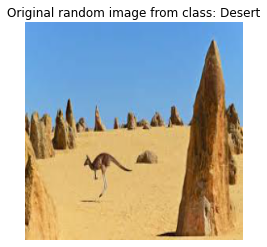

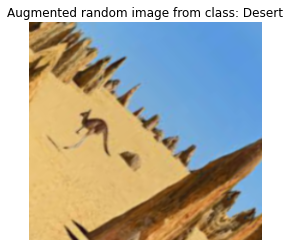

In [ ]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data.class_names) # choose a random class
target_dir = "/content/Landscape Classification/Landscape Classification/Training Data/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image.
img = tf.image.resize(img/255., [224,224])
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image

img = tf.cast(tf.expand_dims(img, axis=0), tf.float32)
augmented_img = data_augmentation(img,training=True) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

In [ ]:
# Create checkpoint callback to save model for later use
checkpoint_model_2_path = "/content/model_2_checkpoint"
checkpoint_callback_model_2 = tf.keras.callbacks.ModelCheckpoint(checkpoint_model_2_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs, training=True)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(5, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_2 = keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_model_2 = model_2.fit(train_data,
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=validation_data,
                    validation_steps=int(0.25* len(validation_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("Tensor_Board", "Transfer_learning_fiture_ext_5_epochs_aug"),
                               checkpoint_callback_model_2])

Saving TensorBoard log files to: Tensor_Board/Transfer_learning_fiture_ext_5_epochs_aug/20230104-153729
Epoch 1/5
313/313 [==============================] - 106s 318ms/step - loss: 0.7311 - accuracy: 0.7312 - val_loss: 0.7038 - val_accuracy: 0.7415
Epoch 2/5
313/313 [==============================] - 75s 240ms/step - loss: 0.5271 - accuracy: 0.8086 - val_loss: 0.7252 - val_accuracy: 0.7415
Epoch 3/5
313/313 [==============================] - 66s 211ms/step - loss: 0.4971 - accuracy: 0.8240 - val_loss: 0.7967 - val_accuracy: 0.7301
Epoch 4/5
313/313 [==============================] - 63s 200ms/step - loss: 0.4740 - accuracy: 0.8294 - val_loss: 0.7168 - val_accuracy: 0.7614
Epoch 5/5
313/313 [==============================] - 58s 184ms/step - loss: 0.4509 - accuracy: 0.8405 - val_loss: 0.7065 - val_accuracy: 0.7500


In [ ]:
# Check out model summary
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 5)                 6405      
                                                                 
Total params: 4,055,976
Trainable params: 6,405
Non-trainab

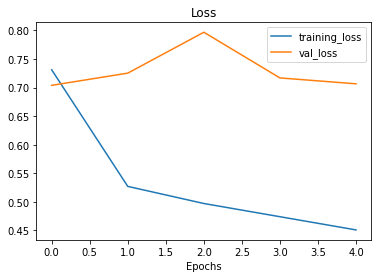

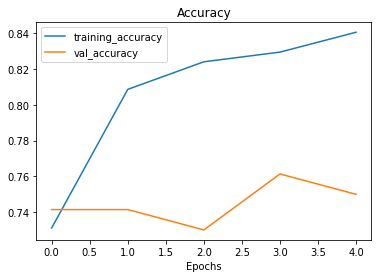

In [ ]:
# How does the model go with a data augmentation layer
plot_loss_curves(history_model_2)

In [ ]:
result_model_2 = model_2.evaluate(test_data)

16/16 [==============================] - 3s 165ms/step - loss: 0.4575 - accuracy: 0.8280


#Model 3: Feature extraction transfer learning 10 epochs with data augmentation

In [ ]:
# Create checkpoint callback to save model for later use
checkpoint_model_3_path = "/content/model_3_checkpoint"
checkpoint_callback_model_3 = tf.keras.callbacks.ModelCheckpoint(checkpoint_model_3_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs, training = True)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(5, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_3 = keras.Model(inputs, outputs)

# Compile the model
model_3.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_model_3 = model_3.fit(train_data,
                    epochs=10,
                    steps_per_epoch=len(train_data),
                    validation_data=validation_data,
                    validation_steps=int(0.25* len(validation_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("Tensor_Board", "Transfer_learning_fiture_ext_10_epochs_aug"),
                               checkpoint_callback_model_3])

Saving TensorBoard log files to: Tensor_Board/Transfer_learning_fiture_ext_10_epochs_aug/20230104-154511
Epoch 1/10
313/313 [==============================] - 61s 175ms/step - loss: 0.7307 - accuracy: 0.7384 - val_loss: 0.7501 - val_accuracy: 0.7330
Epoch 2/10
313/313 [==============================] - 54s 172ms/step - loss: 0.5339 - accuracy: 0.8057 - val_loss: 0.7369 - val_accuracy: 0.7244
Epoch 3/10
313/313 [==============================] - 50s 158ms/step - loss: 0.4850 - accuracy: 0.8256 - val_loss: 0.6618 - val_accuracy: 0.7386
Epoch 4/10
313/313 [==============================] - 47s 148ms/step - loss: 0.4661 - accuracy: 0.8298 - val_loss: 0.7993 - val_accuracy: 0.7216
Epoch 5/10
313/313 [==============================] - 46s 146ms/step - loss: 0.4560 - accuracy: 0.8366 - val_loss: 0.6497 - val_accuracy: 0.7670
Epoch 6/10
313/313 [==============================] - 44s 140ms/step - loss: 0.4387 - accuracy: 0.8403 - val_loss: 0.6972 - val_accuracy: 0.7472
Epoch 7/10
313/313 [=====

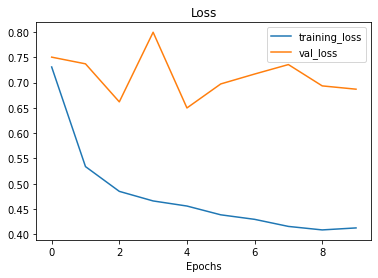

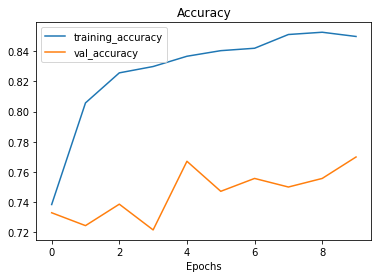

In [ ]:
# How does the model go with a data augmentation layer
plot_loss_curves(history_model_3)

In [ ]:
result_model_3 = model_3.evaluate(test_data)

16/16 [==============================] - 2s 141ms/step - loss: 0.4207 - accuracy: 0.8360


#Model 4: Fine-tuning an existing model

In [ ]:
result_model_0, result_model_1, result_model_2, result_model_3,

([0.2875811755657196, 0.8880000114440918],
 [0.27843549847602844, 0.8880000114440918],
 [0.45751136541366577, 0.828000009059906],
 [0.4206855893135071, 0.8360000252723694])

In [ ]:
initial_epochs = 5

In [ ]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers[-20:]):
  print(layer_number, layer.name, layer.trainable)

0 block6d_project_conv False
1 block6d_project_bn False
2 block6d_drop False
3 block6d_add False
4 block7a_expand_conv False
5 block7a_expand_bn False
6 block7a_expand_activation False
7 block7a_dwconv False
8 block7a_bn False
9 block7a_activation False
10 block7a_se_squeeze False
11 block7a_se_reshape False
12 block7a_se_reduce False
13 block7a_se_expand False
14 block7a_se_excite False
15 block7a_project_conv False
16 block7a_project_bn False
17 top_conv False
18 top_bn False
19 top_activation False


In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 5)                 6405      
                                                                 
Total params: 4,055,976
Trainable params: 6,405
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model_0.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

In [ ]:
# Check which layers are trainable
for layer_number, layer in enumerate(base_model.layers[-20:]):
  print(layer_number, layer.name, layer.trainable)

0 block6d_project_conv False
1 block6d_project_bn False
2 block6d_drop False
3 block6d_add False
4 block7a_expand_conv False
5 block7a_expand_bn False
6 block7a_expand_activation False
7 block7a_dwconv False
8 block7a_bn False
9 block7a_activation False
10 block7a_se_squeeze True
11 block7a_se_reshape True
12 block7a_se_reduce True
13 block7a_se_expand True
14 block7a_se_excite True
15 block7a_project_conv True
16 block7a_project_bn True
17 top_conv True
18 top_bn True
19 top_activation True


In [ ]:
print(len(model_0.trainable_variables))

2


In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 5)                 6405      
                                                                 
Total params: 4,055,976
Trainable params: 6,405
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# Create checkpoint callback to save model for later use
checkpoint_model_0_fine_tune_path = "/content/model_0_fine_tune_checkpoint"
checkpoint_callback_model_0_fine_tune = tf.keras.callbacks.ModelCheckpoint(checkpoint_model_0_fine_tune_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)

In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_0 except with more trainable layers)
history_model_0_fine_tune = model_0.fit(train_data,
                                        epochs=fine_tune_epochs,
                                        validation_data=validation_data,
                                        initial_epoch=history_model_0.epoch[-1], # start from previous last epoch
                                        validation_steps=int(0.25* len(validation_data)),
                                        callbacks=[create_tensorboard_callback("Tensor_Board", "Transfer_learning_fine_tune_10_epochs"),
                                                   checkpoint_callback_model_0_fine_tune]) # name expe

Saving TensorBoard log files to: Tensor_Board/Transfer_learning_fine_tune_10_epochs/20230104-155519
Epoch 5/10
313/313 [==============================] - 31s 81ms/step - loss: 0.2592 - accuracy: 0.9167 - val_loss: 0.5168 - val_accuracy: 0.8295
Epoch 6/10
313/313 [==============================] - 24s 76ms/step - loss: 0.2548 - accuracy: 0.9160 - val_loss: 0.4757 - val_accuracy: 0.8523
Epoch 7/10
313/313 [==============================] - 24s 75ms/step - loss: 0.2531 - accuracy: 0.9157 - val_loss: 0.5190 - val_accuracy: 0.8182
Epoch 8/10
313/313 [==============================] - 24s 76ms/step - loss: 0.2537 - accuracy: 0.9177 - val_loss: 0.4857 - val_accuracy: 0.8494
Epoch 9/10
313/313 [==============================] - 24s 76ms/step - loss: 0.2502 - accuracy: 0.9190 - val_loss: 0.4305 - val_accuracy: 0.8523
Epoch 10/10
313/313 [==============================] - 24s 75ms/step - loss: 0.2488 - accuracy: 0.9178 - val_loss: 0.5209 - val_accuracy: 0.8324


In [ ]:
# Evaluate the model on the test data
results_model_0_fine_tune = model_0.evaluate(test_data)

16/16 [==============================] - 1s 73ms/step - loss: 0.2652 - accuracy: 0.8940


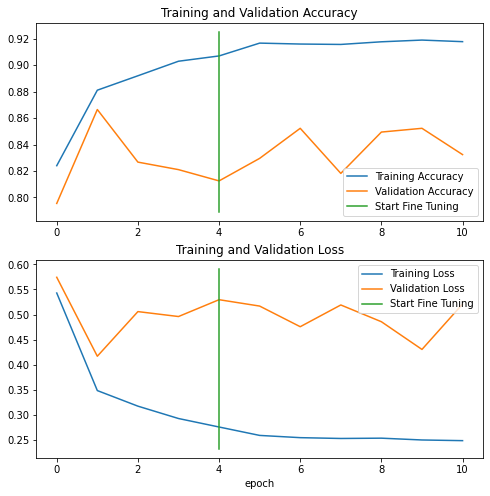

In [ ]:
compare_historys(original_history=history_model_0, 
                 new_history=history_model_0_fine_tune, 
                 initial_epochs=5)

In [ ]:
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

# Viewing our experiment data on TensorBoard

In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./Tensor_Board \
  --name "Transfer learning experiments" \
  --description "A series of different transfer learning experiments with fine-tuning" \
  --one_shot # exits the uploader when upload has finished


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/jqdJRF9jTjSOGjwf7WjgZQ/

[2023-01-04T15:58:29] Started scanning logdir.
[2023-01-04T15:58:41] Total uploaded: 432 scalars, 0 tensors, 12 binary objects (9.5 MB)
[2023-01-04T15:58:41] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/jqdJRF9jTjSOGjwf7WjgZQ/


In [ ]:
# Done. View your TensorBoard at https://tensorboard.dev/experiment/jqdJRF9jTjSOGjwf7WjgZQ/

# Evaluating and visualizing our models predictions

In [ ]:
# Make predictions with model
prediction_probability = model_0.predict(test_data, verbose=1) # set verbosity to see how long it will take 

16/16 [==============================] - 2s 71ms/step


In [ ]:
# Get the class predicitons of each label
pred_classes = prediction_probability.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# Check to see if loaded model is a trained model
loaded_loss, loaded_accuracy = model_0.evaluate(test_data)
loaded_loss, loaded_accuracy

16/16 [==============================] - 1s 73ms/step - loss: 0.2652 - accuracy: 0.8940


(0.26516860723495483, 0.8939999938011169)

In [ ]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.894

In [ ]:
# Evaluate method compare to the Scikit-Learn measured accuracy
import numpy as np
print(f"Close? {np.isclose(loaded_accuracy, sklearn_accuracy)} | Difference: {loaded_accuracy - sklearn_accuracy}")

Close? True | Difference: -6.198883073516015e-09


In [ ]:
# Get the class names
class_names = test_data.class_names
class_names

['Coast', 'Desert', 'Forest', 'Glacier', 'Mountain']

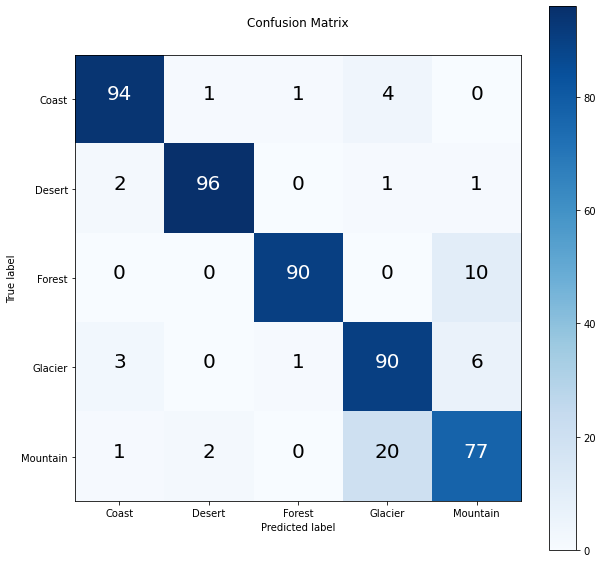

In [ ]:
# Plot a confusion matrix with all predictions, ground truth labels
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(10, 10),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [ ]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       100
           1       0.97      0.96      0.96       100
           2       0.98      0.90      0.94       100
           3       0.78      0.90      0.84       100
           4       0.82      0.77      0.79       100

    accuracy                           0.89       500
   macro avg       0.90      0.89      0.89       500
weighted avg       0.90      0.89      0.89       500



In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.94, 'recall': 0.94, 'f1-score': 0.94, 'support': 100},
 '1': {'precision': 0.9696969696969697,
  'recall': 0.96,
  'f1-score': 0.964824120603015,
  'support': 100},
 '2': {'precision': 0.9782608695652174,
  'recall': 0.9,
  'f1-score': 0.9375,
  'support': 100},
 '3': {'precision': 0.782608695652174,
  'recall': 0.9,
  'f1-score': 0.8372093023255814,
  'support': 100},
 '4': {'precision': 0.8191489361702128,
  'recall': 0.77,
  'f1-score': 0.7938144329896908,
  'support': 100},
 'accuracy': 0.894,
 'macro avg': {'precision': 0.8979430942169147,
  'recall': 0.8939999999999999,
  'f1-score': 0.8946695711836575,
  'support': 500},
 'weighted avg': {'precision': 0.8979430942169147,
  'recall': 0.894,
  'f1-score': 0.8946695711836574,
  'support': 500}}

In [ ]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'Coast': 0.94,
 'Desert': 0.964824120603015,
 'Forest': 0.9375,
 'Glacier': 0.8372093023255814,
 'Mountain': 0.7938144329896908}

In [ ]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

,class_name,f1-score
1,Desert,0.964824
0,Coast,0.940000
2,Forest,0.937500
3,Glacier,0.837209
4,Mountain,0.793814


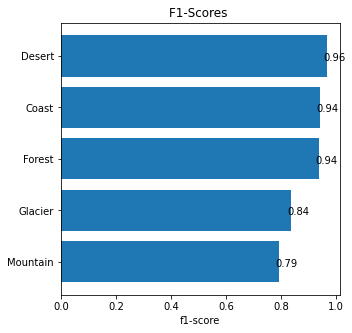

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores ")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

1/1 [==============================] - 0s 23ms/step


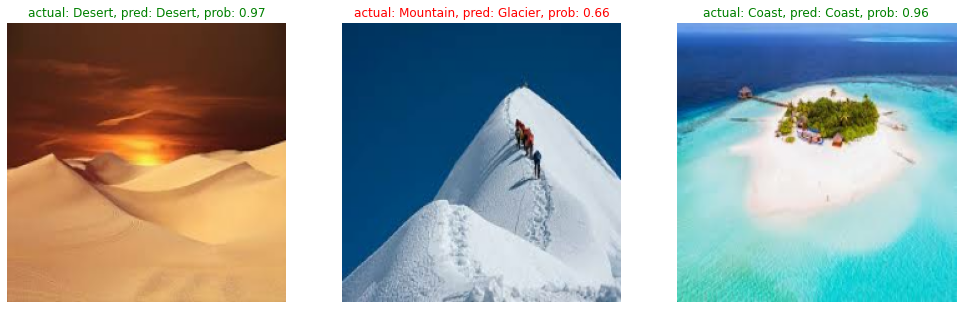

In [ ]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = test_data.class_names
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir_path + "/" + class_name))
  filepath = test_dir_path +'/'+ class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model_0.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

#Finding the most wrong predictions

In [ ]:
# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files('Landscape Classification/Landscape Classification/Testing Data/*/*.jpeg', 
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'Landscape Classification/Landscape Classification/Testing Data/Coast/Coast-Test (1).jpeg',
 b'Landscape Classification/Landscape Classification/Testing Data/Coast/Coast-Test (100).jpeg',
 b'Landscape Classification/Landscape Classification/Testing Data/Coast/Coast-Test (101).jpeg',
 b'Landscape Classification/Landscape Classification/Testing Data/Coast/Coast-Test (102).jpeg',
 b'Landscape Classification/Landscape Classification/Testing Data/Coast/Coast-Test (103).jpeg',
 b'Landscape Classification/Landscape Classification/Testing Data/Coast/Coast-Test (104).jpeg',
 b'Landscape Classification/Landscape Classification/Testing Data/Coast/Coast-Test (105).jpeg',
 b'Landscape Classification/Landscape Classification/Testing Data/Coast/Coast-Test (106).jpeg',
 b'Landscape Classification/Landscape Classification/Testing Data/Coast/Coast-Test (107).jpeg',
 b'Landscape Classification/Landscape Classification/Testing Data/Coast/Coast-Test (108).jpeg']

In [ ]:
# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": prediction_probability.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,b'Landscape Classification/Landscape Classific...,0,0,0.998736,Coast,Coast
1,b'Landscape Classification/Landscape Classific...,0,0,0.994345,Coast,Coast
2,b'Landscape Classification/Landscape Classific...,0,0,0.922341,Coast,Coast
3,b'Landscape Classification/Landscape Classific...,0,0,0.991550,Coast,Coast
4,b'Landscape Classification/Landscape Classific...,0,0,0.996406,Coast,Coast


In [ ]:
# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'Landscape Classification/Landscape Classific...,0,0,0.998736,Coast,Coast,True
1,b'Landscape Classification/Landscape Classific...,0,0,0.994345,Coast,Coast,True
2,b'Landscape Classification/Landscape Classific...,0,0,0.922341,Coast,Coast,True
3,b'Landscape Classification/Landscape Classific...,0,0,0.991550,Coast,Coast,True
4,b'Landscape Classification/Landscape Classific...,0,0,0.996406,Coast,Coast,True


In [ ]:
# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
393,b'Landscape Classification/Landscape Classific...,3,4,0.963685,Glacier,Mountain,False
285,b'Landscape Classification/Landscape Classific...,2,4,0.944348,Forest,Mountain,False
426,b'Landscape Classification/Landscape Classific...,4,3,0.940519,Mountain,Glacier,False
223,b'Landscape Classification/Landscape Classific...,2,4,0.930494,Forest,Mountain,False
454,b'Landscape Classification/Landscape Classific...,4,3,0.924664,Mountain,Glacier,False
52,b'Landscape Classification/Landscape Classific...,0,1,0.915249,Coast,Desert,False
450,b'Landscape Classification/Landscape Classific...,4,3,0.852681,Mountain,Glacier,False
15,b'Landscape Classification/Landscape Classific...,0,3,0.852525,Coast,Glacier,False
482,b'Landscape Classification/Landscape Classific...,4,3,0.849329,Mountain,Glacier,False
207,b'Landscape Classification/Landscape Classific...,2,4,0.843576,Forest,Mountain,False


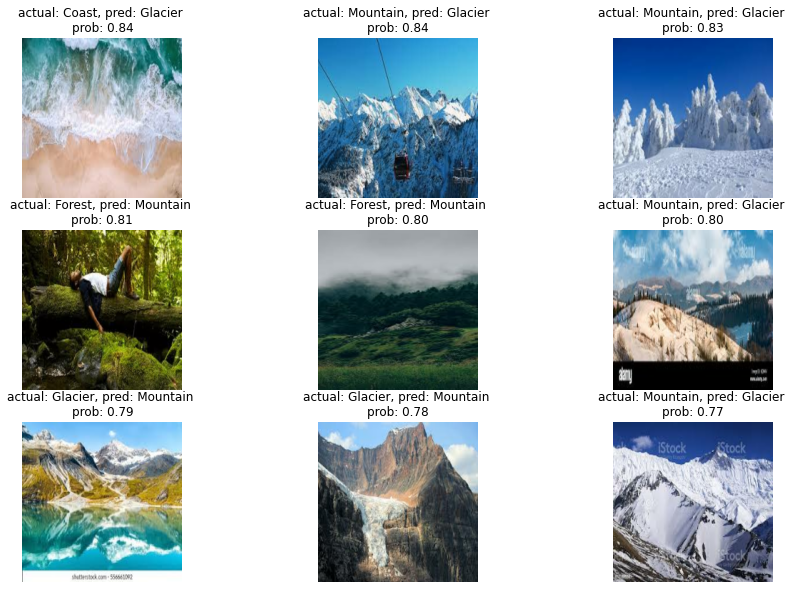

In [ ]:
# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)